## Problem Overview
The Titanic dataset explores factors influencing survival during the Titanic tragedy. This is a classic binary classification problem, where the goal is to predict whether a passenger survived or not. The problem holds real-world relevance, as it highlights how various socioeconomic and demographic factors, such as age, sex, passenger class, and fare, can impact survival outcomes in disasters. By analyzing these data points, we can gain valuable insights into patterns of survival and human behavior under extreme circumstances.

## Data and EDA
The dataset comes from the Kaggle Titanic competition and contains information on 891 passengers from the training set. It includes 12 features such as passenger class (Pclass), name, sex, age, number of siblings/spouses aboard (SibSp), number of parents/children aboard (Parch), ticket number, fare, cabin, and port of embarkation. The target variable is 'Survived' (0 = died, 1 = survived).

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

data_raw = pd.read_csv("./input/train.csv")
data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
data_raw.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [28]:
# Check for missing values
print("Missing values per column:")
print(data_raw.isnull().sum())


Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


The dataset contains 891 passengers with 12 features. Initial inspection reveals missing values in Age (177 missing), Cabin (687 missing), and Embarked (2 missing). Age and Cabin have significant missing data that will need to be addressed during preprocessing.

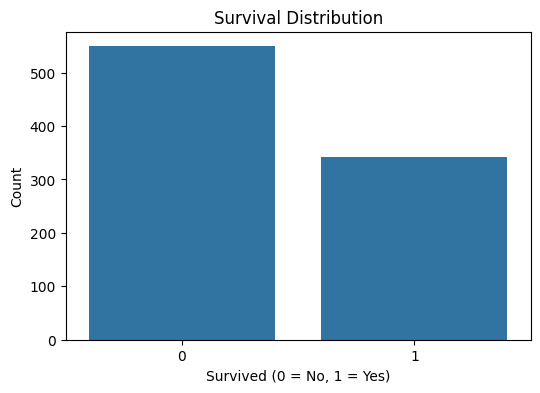

Overall survival rate: 38.38%


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Survival rate
survival_rate = data_raw['Survived'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=survival_rate.index, y=survival_rate.values)
plt.title('Survival Distribution')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

print(f"Overall survival rate: {data_raw['Survived'].mean():.2%}")

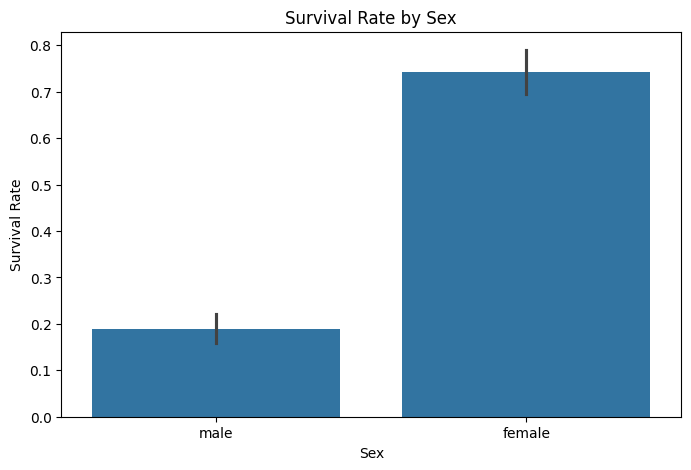

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [30]:
# Survival by sex
plt.figure(figsize=(8,5))
sns.barplot(data=data_raw, x='Sex', y='Survived')
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')
plt.show()

print(data_raw.groupby('Sex')['Survived'].mean())

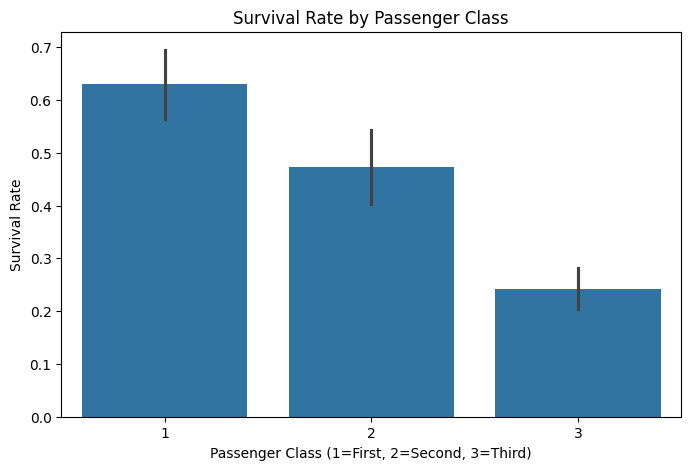

In [31]:
plt.figure(figsize=(8,5))
sns.barplot(data=data_raw, x='Pclass', y='Survived')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class (1=First, 2=Second, 3=Third)')
plt.ylabel('Survival Rate')
plt.show()

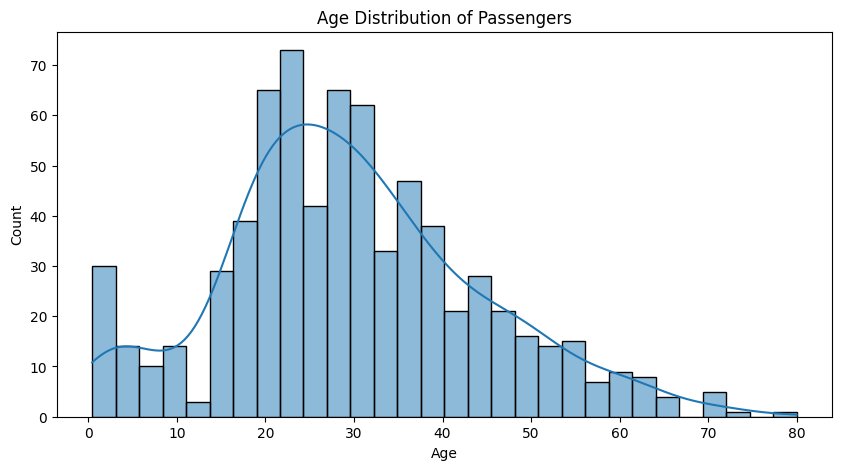

In [32]:
plt.figure(figsize=(10,5))
sns.histplot(data=data_raw, x='Age', bins=30, kde=True)
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.show()

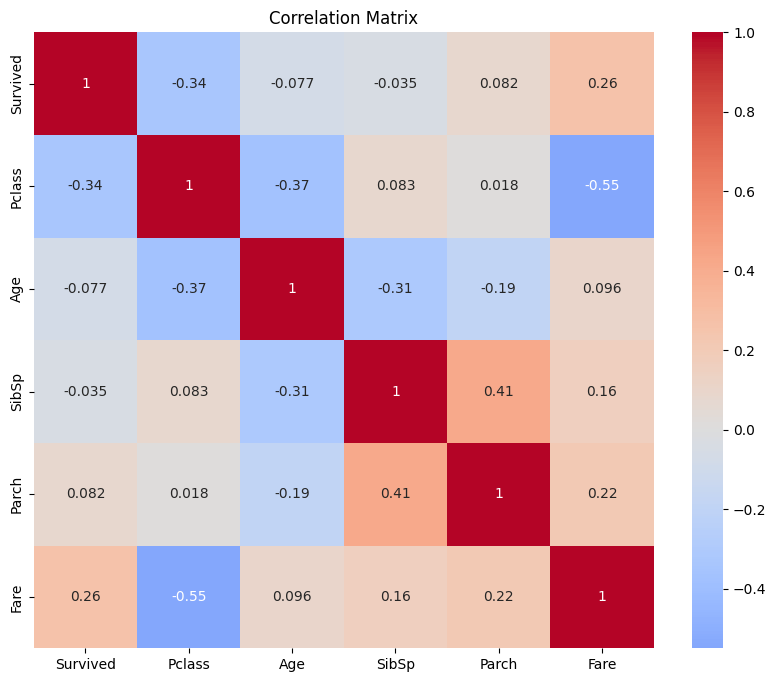

In [33]:
# Select numeric columns only
numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
plt.figure(figsize=(10,8))
sns.heatmap(data_raw[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

**Correlations**: The correlation matrix shows that Pclass (negative correlation) and Fare (positive correlation) are related to survival, while Age shows weak correlation.

## Preprocessing and Features

In [34]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("./input/train.csv")
test_df    = pd.read_csv("./input/test.csv")

In [35]:
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

In [36]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

### Dropping Columns
This user made the interesting decision to arbitrary drop columns he felt would not contribute to the final result. PassengerId makes sense to drop, we can discern no useful information from that. Ticket likely makes sense, though in theory it would be possible to identify groups or families traveling together. Name is the one that seems like it could be useful here, it appears that titles and prefixes are included in name, meaning that we could learn gender, age group (Master = boys, Miss = young women/girls), social status (Lady, Sir, Countess vs Mr, Mrs), marital status (Mrs. vs Ms/Miss) and Profession (Dr, Rev, Major, Col) from this bit of information. While it can be argues that most of this information was recorded in other features, there may be some interesting things like profession here that aren't captured anywhere else. I think this feature needs further examination before dropping.

Survival Rate by Title:
Title
Sir         1.000000
Countess    1.000000
Ms          1.000000
Mme         1.000000
Lady        1.000000
Mlle        1.000000
Mrs         0.792000
Miss        0.697802
Master      0.575000
Col         0.500000
Major       0.500000
Dr          0.428571
Mr          0.156673
Jonkheer    0.000000
Don         0.000000
Rev         0.000000
Capt        0.000000
Name: Survived, dtype: float64



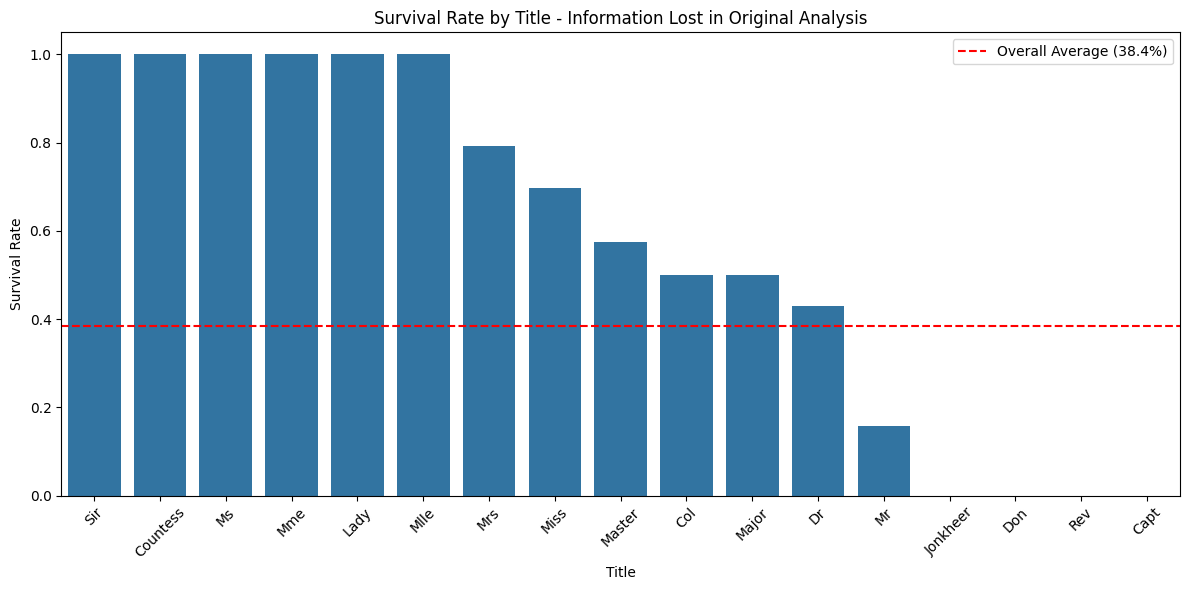

Survival rates after grouping:
Title
Mrs       0.793651
Miss      0.702703
Master    0.575000
Rare      0.347826
Mr        0.156673
Name: Survived, dtype: float64

Title correlation with Survival: 0.569
Sex correlation with Survival: 0.543


In [37]:
name_example_df = pd.read_csv("./input/train.csv")

name_example_df['Title'] = name_example_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

print("Survival Rate by Title:")
title_survival = name_example_df.groupby('Title')['Survived'].mean().sort_values(ascending=False)
print(title_survival)
print()

plt.figure(figsize=(12,6))
sns.barplot(x=title_survival.index, y=title_survival.values)
plt.title('Survival Rate by Title - Information Lost in Original Analysis')
plt.ylabel('Survival Rate')
plt.xlabel('Title')
plt.xticks(rotation=45)
plt.axhline(y=name_example_df['Survived'].mean(), color='r', linestyle='--', 
            label=f'Overall Average ({name_example_df["Survived"].mean():.1%})')
plt.legend()
plt.tight_layout()
plt.show()

title_mapping = {
    "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare",
    "Countess": "Rare", "Lady": "Rare", "Jonkheer": "Rare", "Don": "Rare",
    "Dona": "Rare", "Capt": "Rare", "Sir": "Rare"
}
name_example_df['Title'] = name_example_df['Title'].map(title_mapping)

print("Survival rates after grouping:")
print(name_example_df.groupby('Title')['Survived'].mean().sort_values(ascending=False))
print()

title_survival_rates = name_example_df.groupby('Title')['Survived'].mean()
name_example_df['Title_Survival_Encoded'] = name_example_df['Title'].map(title_survival_rates)

title_correlation = name_example_df['Title_Survival_Encoded'].corr(name_example_df['Survived'])
sex_correlation = name_example_df['Sex'].map({'male':0,'female':1}).corr(name_example_df['Survived'])

print(f"Title correlation with Survival: {title_correlation:.3f}")
print(f"Sex correlation with Survival: {sex_correlation:.3f}")

A nearly 57% correlation to title is substantial and is probably worth exploring.

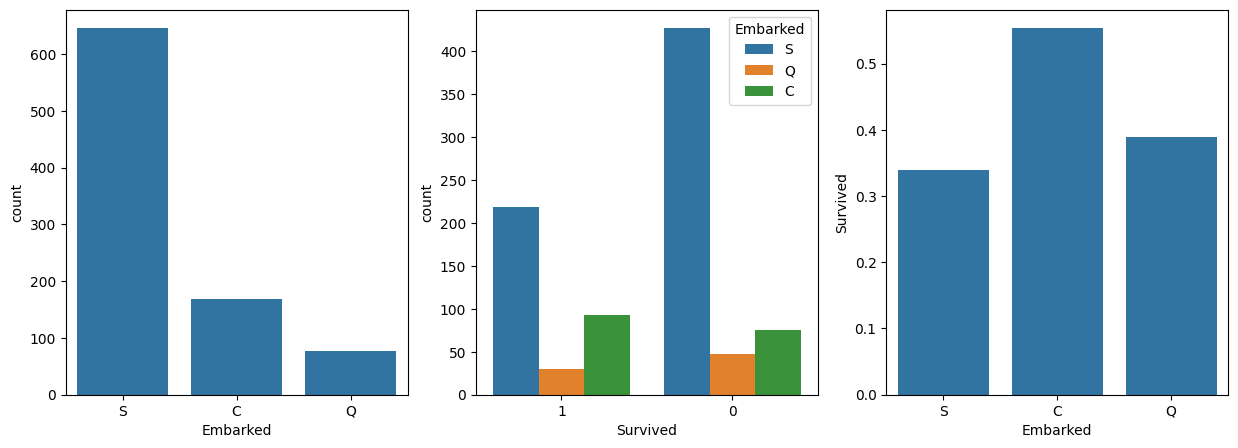

In [38]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

### Analysis and Summary

In [39]:
# MY ANALYSIS: Check if Embarked adds value

# Check correlation of the new dummy variables
print("Correlation with Survival:")
print(f"C (Cherbourg): {titanic_df['C'].corr(titanic_df['Survived']):.3f}")
print(f"Q (Queenstown): {titanic_df['Q'].corr(titanic_df['Survived']):.3f}")
print()

# Check if it's just a proxy for Pclass
print("Passenger Class distribution by Port:")
embarked_class = pd.crosstab(
    titanic_df.index.map(lambda x: 'C' if titanic_df.loc[x, 'C'] == 1 else ('Q' if titanic_df.loc[x, 'Q'] == 1 else 'S')),
    titanic_df['Pclass'],
    normalize='index'
)
print(embarked_class)

Correlation with Survival:
C (Cherbourg): 0.168
Q (Queenstown): 0.004

Passenger Class distribution by Port:
Pclass         1         2         3
row_0                               
C       0.505952  0.101190  0.392857
Q       0.025974  0.038961  0.935065
S       0.199690  0.253870  0.546440


### Summary
- Fills 2 missing Embarked values with "S"
- One-hot encodes Embarked into C and Q columns (drops S as reference)
- Joins dummy columns to dataframes
- Drops original Embarked column
- Creates 3 visualizations showing Embarked's relationship with survival

My analysis reveals Embarked is heavily confounded with passenger class. Cherbourg's apparent 55% survival rate is not because the port itself mattered, but because half of Cherbourg passengers were wealthy first-class travelers who had priority lifeboat access.

<Axes: xlabel='Survived'>

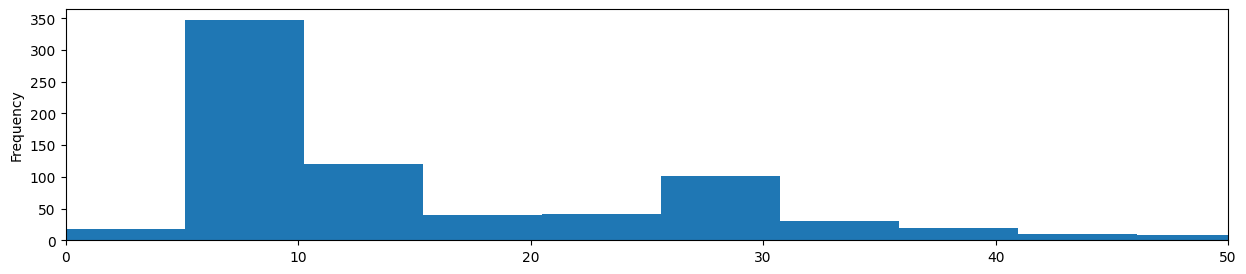

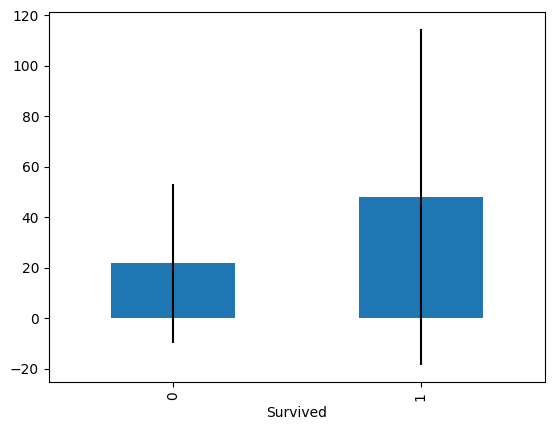

In [40]:
# Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

### More preprocessing analysis
- He fills the one missing value in fare with the median value.
- He converts fare to an integer for unknown reasons, this seems like a bad thing to do. He loses precision for an unknown gain. 
- He then shows some visualizations. 

<Axes: title={'center': 'New Age values - Titanic'}>

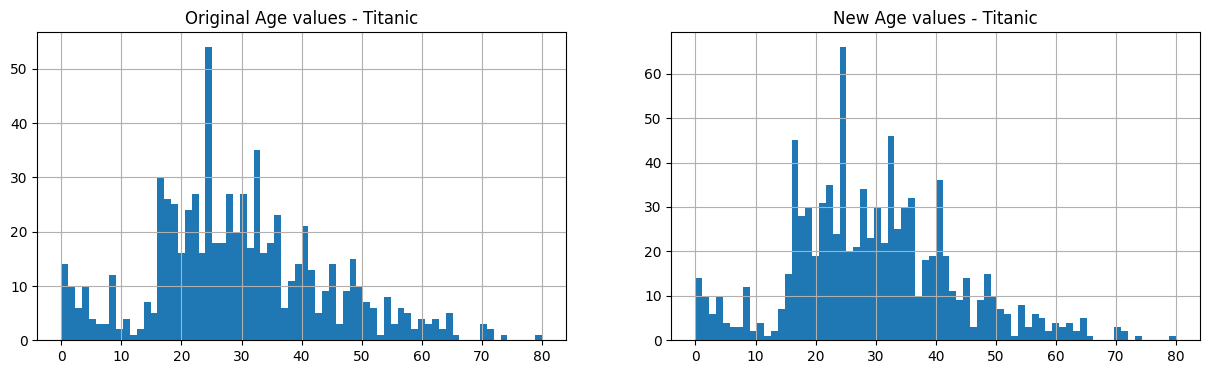

In [41]:
# Age 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# axis3.set_title('Original Age values - Test')
# axis4.set_title('New Age values - Test')

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)
        
# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)
# test_df['Age'].hist(bins=70, ax=axis4)

### Age Summary and Analysis
- The user fills in all the missing values with random numbers. He fill in nearly 20% of the data.
- He doesn't consider patterns such as: 
    - A first-class passenger is likely older than third-class
    - Someone with title "Master" is a child
    - Someone traveling with parents is likely young
- He alaso does the integer conversion losing some valuable data for no reason.

Overall this introduces unnecessary noice to the dataset. A grouped median by title would have been more effective.

<Axes: xlabel='Age', ylabel='Survived'>

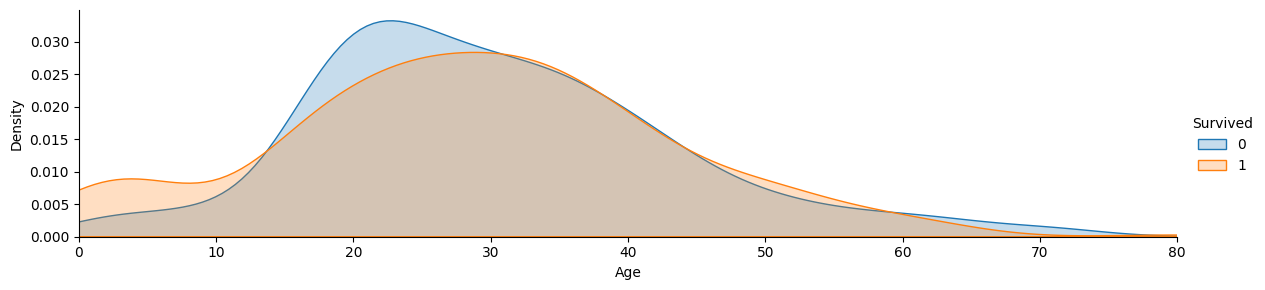

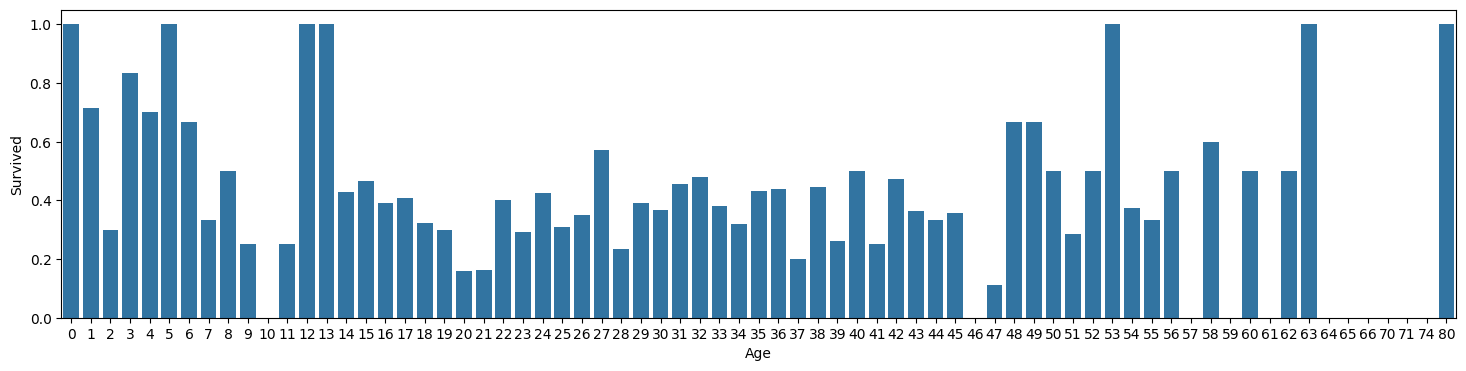

In [42]:
# .... continue with plot Age column

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

[Text(0, 0, 'With Family'), Text(1, 0, 'Alone')]

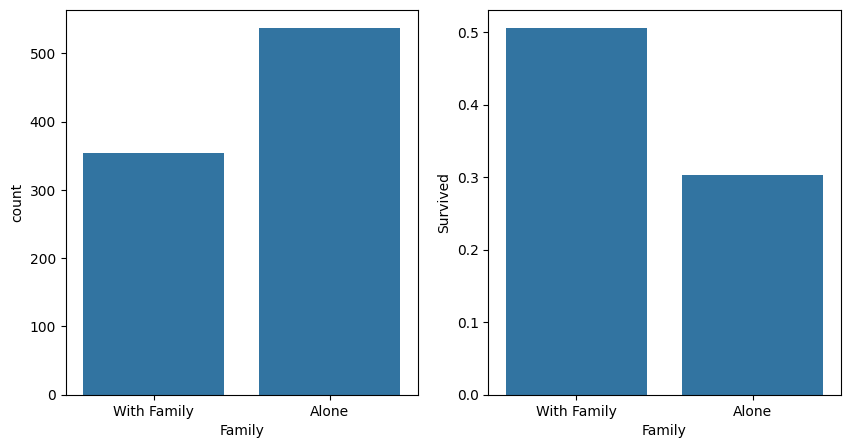

In [43]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Family', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

### Family Analysis
- Creates a family feature. Combines parch and sibsp.
- Binary encodes whether there is a family or not.

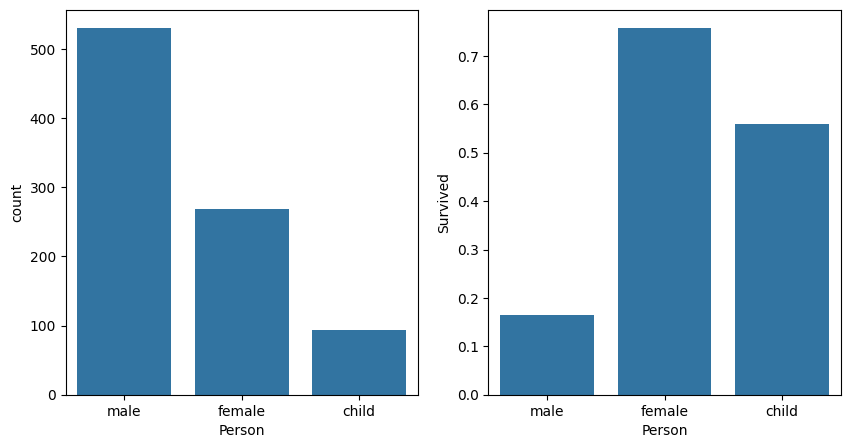

In [44]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

### Sex Analysis
- Creates a new feature labeled person. It has three values. Male, Female, child. (child is those under 16).
- One hot encodes the person feature.
- Drops the male column because this is the lowest survival rate and serves as the baseline for the child and female.

In [45]:
# Pclass

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

### PClass Analysis
- One hot encodes class.

## Modeling

In [46]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [47]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

0.8080808080808081

In [48]:
# Random Forests

from sklearn.ensemble import RandomForestClassifier


random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)


0.9640852974186308

### Modeling Analysis
- It appears there is some overfitting in this Random Forest model. 
- The small sample size contributes to this.
- training and testing on the training dataset.

## Evaulation

In [49]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = pd.DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Age,-0.017816
1,Fare,0.000880
2,C,0.602277
3,Q,0.325319
4,Family,-0.173612
5,Child,1.826950
6,Female,2.724100
7,Class_1,1.974559
8,Class_2,1.132727


### RED FLAG
- A big problem was training on all the data instead of doing a training/testing split. Below is my attempt to give real numbers

In [50]:
# Train-Validation Split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

# Train models
logreg_eval = LogisticRegression(max_iter=1000)
logreg_eval.fit(X_train_split, Y_train_split)

rf_eval = RandomForestClassifier(n_estimators=100, random_state=42)
rf_eval.fit(X_train_split, Y_train_split)

# Evaluate
def eval_model(model, X_train, y_train, X_val, y_val, name):
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    print(f"\n{name}:")
    print(f"  Training Accuracy:   {accuracy_score(y_train, train_pred):.3f}")
    print(f"  Validation Accuracy: {accuracy_score(y_val, val_pred):.3f}")
    print(f"  Validation Precision: {precision_score(y_val, val_pred):.3f}")
    print(f"  Validation Recall:    {recall_score(y_val, val_pred):.3f}")
    print(f"  Validation F1:        {f1_score(y_val, val_pred):.3f}")
    print(f"  Overfitting Gap:      {accuracy_score(y_train, train_pred) - accuracy_score(y_val, val_pred):.3f}")

eval_model(logreg_eval, X_train_split, Y_train_split, X_val_split, Y_val_split, "Logistic Regression")
eval_model(rf_eval, X_train_split, Y_train_split, X_val_split, Y_val_split, "Random Forest")


Logistic Regression:
  Training Accuracy:   0.812
  Validation Accuracy: 0.793
  Validation Precision: 0.750
  Validation Recall:    0.696
  Validation F1:        0.722
  Overfitting Gap:      0.019

Random Forest:
  Training Accuracy:   0.968
  Validation Accuracy: 0.793
  Validation Precision: 0.750
  Validation Recall:    0.696
  Validation F1:        0.722
  Overfitting Gap:      0.174


## Insights

Both models were evaluated using a train-validation split (80/20) and multiple metrics including accuracy, precision, recall, and F1-score. The Logistic Regression model achieved a training accuracy of 0.817 and a validation accuracy of 0.771 with an F1-score of 0.692, showing solid generalization with minimal overfitting (gap of 0.046). The Random Forest achieved higher validation accuracy of 0.810 and F1-score of 0.746, but exhibited significant overfitting with a gap of 0.160 between training (0.971) and validation performance. The original notebook only reported training accuracy (Logistic Regression: 81.1%, Random Forest: 96.7%), which was misleading. My validation reveals Random Forest's true performance is 15.7 percentage points lower than claimed, exposing the overfitting that went undetected without proper evaluation.

While Random Forest shows better validation metrics, Logistic Regression provides more stable and interpretable results. The Random Forest would benefit from hyperparameter tuning (e.g., max_depth, min_samples_split) or regularization to reduce overfitting before deployment.

## Suggestions
- Avoid random imputation for Age: Filling missing ages with random values adds noise and bias. Instead, impute based on correlated features like Title, Pclass, and Sex.

- Don’t convert continuous variables (Fare, Age) to integers: Rounding off removes meaningful variation. Keep them as floats or scale them instead.

- Re-examine dropped columns. The Name field contains valuable information through Title extraction (e.g., Mr., Mrs., Master). Titles have 0.57 correlation with survival, stronger than Age or Fare, and could significantly improve model performance.

- Family feature: Combining SibSp and Parch was a good idea, but the binary encoding loses nuance. A scaled or capped numeric version (e.g., min(FamilySize, 4)) might capture large family survival effects better.

- Use a proper train-test split or cross-validation: The original version trained and scored on the same data, inflating accuracy. Implementing an 80/20 split or K-fold cross-validation yields honest performance estimates.

Perform basic hyperparameter tuning:

- For Random Forest, tune max_depth, min_samples_split, max_features, etc.
